In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os

In [21]:
# Here we collect the hyperparameters we are going to use
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1,
                       lr=0.01, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [22]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [23]:
def pick_2_images(xa ,ya, label_a, xb, yb, label_b, xc, yc, label_c):
    a, b = np.random.choice(3, 2, replace=False)
    if a == 0:
        x1,y1,label_1 = xa,ya,label_a
    elif a == 1:
        x1,y1,label_1 = xb,yb,label_b
    else:
        x1,y1,label_1 = xc,yc,label_c
        
    if b == 0:
        x2,y2,label_2 = xa,ya,label_a
    elif b == 1:
        x2,y2,label_2 = xb,yb,label_b
    else:
        x2,y2,label_2 = xc,yc,label_c
        
    if a!=0 and b!=0:
        x3,y3,label_3 = xa,ya,label_a
    elif a!=1 and b!=1:
        x3,y3,label_3 = xb,yb,label_b
    else:
        x3,y3,label_3 = xc,yc,label_c
        
    return x1,y1,label_1,x2,y2,label_2, x3,y3,label_3

def number_to_binary_vector(number):
    binary_vector = [0] * 10
    binary_vector[number] = 1
    return binary_vector

def spatial_relation_labels(x1,y1,x2,y2):
    
    if y1 == y2 and x1 < x2:
        label = "left"
    elif y1 == y2 and x1 > x2:
        label = "right"
    elif x1 == x2 and y1 < y2:
        label = "above"
    elif x1 == x2 and y1 > y2:
        label = "below"
    elif x1 < x2 and y1 < y2:
        label = "above left"
    elif x1 > x2 and y1 < y2:
        label = "above right"
    elif x1 > x2 and y1 > y2:
        label = "below right"
    else:
        label = "below left"
    return label

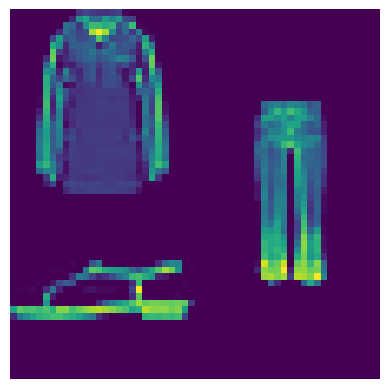

In [24]:
def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):

    samples = []
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)
        idx1, idx2, idx3 = np.random.choice(len(train_loader.dataset), 3, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        img3, label_3 = train_loader.dataset[idx3]
        
        while True:
            if label_1 == label_2:
                idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
                img2, label_2 = train_loader.dataset[idx2]
                continue
            if label_1 == label_3:
                idx3 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
                img3, label_3 = train_loader.dataset[idx3]
                continue
            if label_2 == label_3:
                idx3 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
                img3, label_3 = train_loader.dataset[idx3]
                continue
            break

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        img3 = (img3 - img3.min()) / (img3.max() - img3.min())
        
        a = np.random.randint(0, 4)
        
        if a%2 ==0:
            y1 = 0
            y2 = 28
            y3 = np.random.randint(0, 28)
            if a == 0:
                x1 = 0
                x2 = 0
                x3 = 28
            else:
                x1 = 28
                x2 = 28
                x3 = 0
        else:
            x1 = 0
            x2 = 28
            x3 = np.random.randint(0, 28)
            if a == 1:
                y1 = 0
                y2 = 0
                y3 = 28
            else:
                y1 = 28
                y2 = 28
                y3 = 0
        
        xa ,ya, label_a, xb, yb, label_b, xc, yc, label_c = pick_2_images(x1,y1,label_1,x2,y2,label_2, x3,y3,label_3)
        
        spatial_label = spatial_relation_labels(xa,ya,xb,yb)
        
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        background[:, y3:y3+28, x3:x3+28] = img3

        vector_1 = number_to_binary_vector(label_a)
        vector_2 = number_to_binary_vector(label_b)
        samples.append((background, vector_1, vector_2, spatial_label))

    return samples

## Examples

Example nr 1: 
Input: 
	label 1:  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
	label 2:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


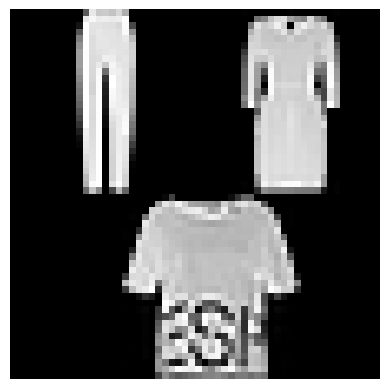

Output:  right 

Example nr 2: 
Input: 
	label 1:  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
	label 2:  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


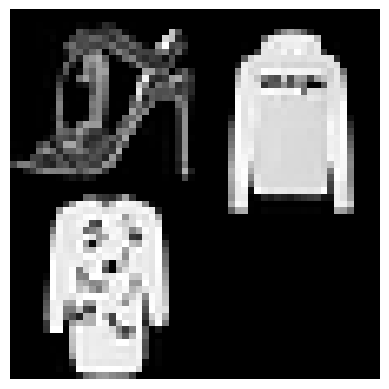

Output:  above right 

Example nr 3: 
Input: 
	label 1:  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
	label 2:  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


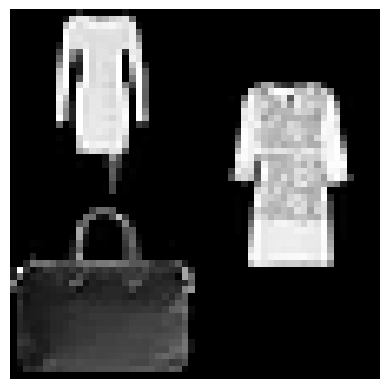

Output:  below 

Example nr 4: 
Input: 
	label 1:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
	label 2:  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


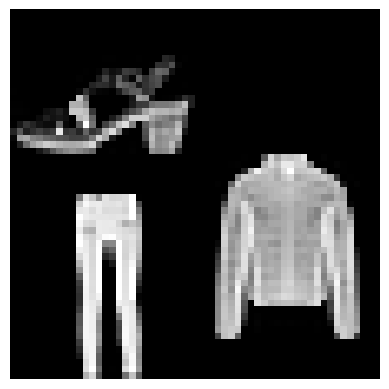

Output:  below left 

Example nr 5: 
Input: 
	label 1:  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
	label 2:  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


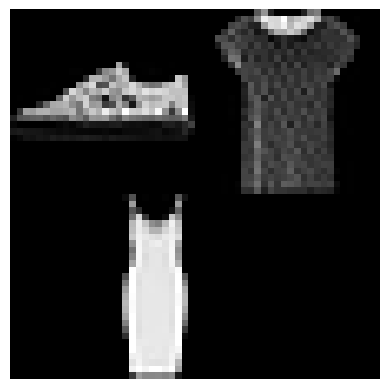

Output:  above left 



In [25]:
samples = create_samples_with_non_overlapping_images_and_vectors(train_loader,5)

for i in range(5):
    img, label_1, label_2, spatial_relation = samples[i]
    print(f"Example nr {i+1}: ")
    print("Input: ")
    print("\tlabel 1: ", label_1)
    print("\tlabel 2: ", label_2)
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Output: ", spatial_relation,"\n")    